In [1]:
import os 
import heapq
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import manifold
from metrics import *
from util import *
data = data_name[0]
path = '../data/'+data+'/'
id_gene,gene_id,g = load_data(path)
# 加载基因模块gold_standed
minimal_path,strict_path = path+'knownmodules/minimal.json',path+'knownmodules/strict.json'
minimal_matrix,minimal_mark = cal_matrix(minimal_path,gene_id.keys())
strict_matrix,strict_mark = cal_matrix(strict_path,gene_id.keys())

Using backend: pytorch
loading ecoli_colombos...


In [72]:
emb = np.load(path+'emb.npy')
matrix = emb
matrix[matrix>0.5] = 1
matrix[matrix<0.5] = 0

res_minimal = adjust(matrix,minimal_mark,top_k = 3)
res_strict = adjust(matrix,strict_mark,top_k = 3)
print('minimal:')
relevance,recovery = cal_overlap(res_minimal,minimal_matrix)
nmi = cal_nmi(res_minimal,minimal_matrix)

print("relevance:{} recovery:{}".format(relevance,recovery))
print("F1 score:{}".format((relevance+recovery)/2))
print("nmi:{}".format(nmi))
print('strict:')
relevance,recovery = cal_overlap(res_strict,strict_matrix)
nmi = cal_nmi(res_strict,strict_matrix)

print("relevance:{} recovery:{}".format(relevance,recovery))
print("F1 score:{}".format((relevance+recovery)/2))
print("nmi:{}".format(nmi))


minimal:
relevance:0.32026907890164086 recovery:0.3152832114446667
F1 score:0.3177761451731538
nmi:0.1345032949796621
strict:
relevance:0.47505959026890804 recovery:0.44463121388901083
F1 score:0.4598454020789594
nmi:0.3542699812613969


<function matplotlib.pyplot.show(close=None, block=None)>

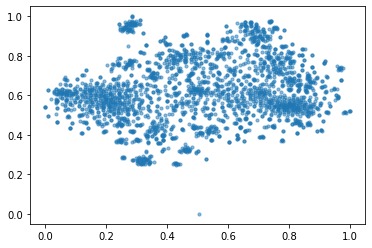

In [73]:
# 初始数据分布
def norm(E):
    eps = 1e-4
    E_var = E.var()
    E_mean = E.mean()
    E_normalized = (E - E_mean) / np.sqrt(E_var + eps)             # 数据归一化标准化
    return np.array(E_normalized.T)

E = pd.read_csv(path+'E.tsv',sep = '\t',index_col = 0)
feat = norm(E)

tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(feat)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.scatter(X_norm[:,0],X_norm[:,1],s = 10,alpha = 0.5)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

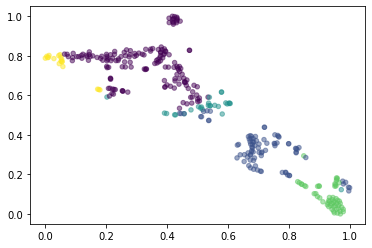

In [74]:
# Deepgmd选取5个最大的模块进行可视化
emb = np.load(path+'emb.npy')
n_largest=5
cmp = heapq.nlargest(n_largest,range(len(matrix.sum(0))),matrix.sum(0).take)
node = np.where(matrix[:,cmp].sum(1)!= 0)[0]
select = matrix[node][:,cmp]
color = np.argmax(select,1)
size = np.ones(len(node))*20

tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(emb[node,:])
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.scatter(X_norm[:,0],X_norm[:,1],c = color,s= size,alpha = 0.5)
plt.show

loading ecoli_colombos...
100%|██████████| 919/919 [00:04<00:00, 226.48it/s]
loading ecoli_dream5...
100%|██████████| 776/776 [00:02<00:00, 270.69it/s]
loading yeast_gpl2529...
100%|██████████| 490/490 [00:01<00:00, 427.74it/s]
loading yeast_dream5...
100%|██████████| 501/501 [00:01<00:00, 391.44it/s]
loading synth_ecoli...
100%|██████████| 1351/1351 [00:09<00:00, 149.78it/s]
loading synth_yeast...
100%|██████████| 1714/1714 [00:14<00:00, 120.46it/s]


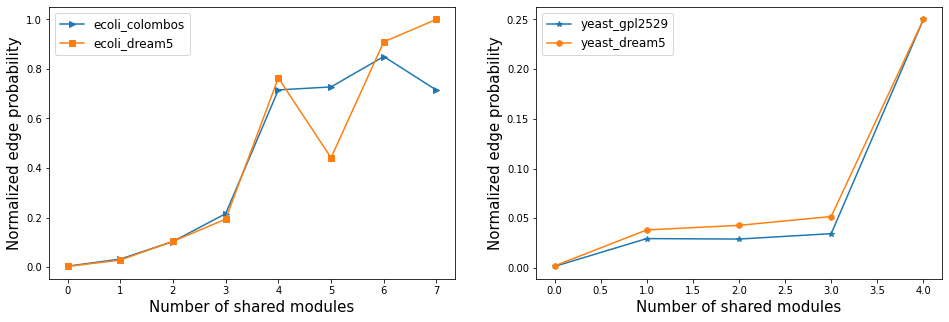

In [3]:
# 绘制模块-节点概率曲线
from tqdm import tqdm
import matplotlib.pyplot as plt
data_name = ["ecoli_colombos", "ecoli_dream5", "yeast_gpl2529", 
"yeast_dream5", "synth_ecoli", "synth_yeast"]
res = []
for data_idx in range(6):
    path = data_name[data_idx]
    path = '../data/'+path+'/'
    id_gene,gene_id,g = load_data(path)

    adj = g.adjacency_matrix().detach().to_dense().numpy()
    res_num = np.zeros(100)
    res_edg = np.zeros(100)

    minimal_path = path+'knownmodules/minimal.json'
    minimal_matrix,minimal_mark= cal_matrix(minimal_path,gene_id.keys())
    idx = np.nonzero(np.array(minimal_mark))[0]
    for i in tqdm(range(minimal_matrix.shape[0])):
        for j in range(i+1,minimal_matrix.shape[0]):
            c = int((minimal_matrix[i] * minimal_matrix[j]).sum())
            res_num[c] += 1
            edge_1,edge_2 = idx[i],idx[j]
            if adj[edge_1][edge_2] == 1:
                res_edg[c] += 1
    res_prob = np.zeros(10)
    for i in range(10):
        a = res_edg[i]
        b = max(res_num[i],1)
        res_prob[i] = a/b
    res.append(res_prob)

# 绘制图形
fontsize = 15
line_type = ["->","-s","-*","-h","-H","-p"]
ecoli = [0,1]
yeast = [2,3]
gs = plt.GridSpec(1,2)
fig = plt.figure(figsize=(16,5))
# 绘制 ecoli
fig.add_subplot(gs[0,0])
for i in ecoli:
    tmp = 0
    for j in range(len(res[i])):
        if res[i][j] == 0:
            tmp = j
            break
    plt.plot(res[i][:tmp],line_type[i])
plt.legend(np.array(data_name)[ecoli], loc=0,fontsize = fontsize-3)
plt.ylabel("Normalized edge probability",fontsize = fontsize)
plt.xlabel("Number of shared modules",fontsize = fontsize)
# 绘制yeast
fig.add_subplot(gs[0,1])
for i in yeast:
    tmp = 0
    for j in range(len(res[i])):
        if res[i][j] == 0:
            tmp = j
            break
    plt.plot(res[i][:tmp],line_type[i])
plt.legend(np.array(data_name)[yeast], loc=0, fontsize = fontsize-3)
plt.ylabel("Normalized edge probability",fontsize = fontsize)
plt.xlabel("Number of shared modules",fontsize = fontsize)
plt.savefig('edge_prob.svg',bbox_inches='tight', pad_inches=0.0)